In [25]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import collections as mc

from ysdc_dataset_api.dataset import MotionPredictionDataset
from ysdc_dataset_api.features import FeatureRenderer
from ysdc_dataset_api.utils import transform_2d_points

In this notebook we give an example on how to render data to image representation and use it with pytorch-style dataset for model training.

## Create a renderer

In [2]:
# Define a renderer config

renderer_config = {
    # parameters of feature maps to render
    'feature_map_params': {
        'rows': 400,
        'cols': 400,
        'resolution': 0.25,  # number of meters in one pixel
    },
    'renderers_groups': [
        # Having several feature map groups
        # allows to independently render feature maps with different history length.
        # This could be useful to render static features (road graph, etc.) once.
        {
            # start: int, first timestamp into the past to render, 0 – prediction time
            # stop: int, last timestamp to render inclusively, 24 – farthest known point into the past
            # step: int, grid step size,
            #            step=1 renders all points between start and stop,
            #            step=2 renders every second point, etc.
            'time_grid_params': {
                'start': 0,
                'stop': 0,
                'step': 1,
            },
            'renderers': [
                # each value is rendered at its own channel
                # occupancy -- 1 channel
                # velocity -- 2 channels (x, y)
                # acceleration -- 2 channels (x, y)
                # yaw -- 1 channel
                {'vehicles': ['occupancy', 'velocity', 'acceleration', 'yaw']},
                # only occupancy and velocity are available for pedestrians
                {'pedestrians': ['occupancy', 'velocity']},
            ]
        },
        {
            'time_grid_params': {
                'start': 0,
                'stop': 0,
                'step': 1,
            },
            'renderers': [
                {
                    'road_graph': [
                        'crosswalk_occupancy',
                        'crosswalk_availability',
                        'lane_availability',
                        'lane_direction',
                        'lane_occupancy',
                        'lane_priority',
                        'lane_speed_limit',
                        'road_polygons',
                    ]
                }
            ]
        }
    ]
}

In [3]:
# Create a renderer instance

renderer = FeatureRenderer(renderer_config)

In [6]:
# Load protobufs for training dataset.
dataset_path = '/path/to/dataset_pb/'

# Path to file with training scene tags. Tags file is located in the raw data archive.
scene_tags_fpath = '/path/to/dataset_pb/tags.txt'

In [7]:
dataset = MotionPredictionDataset(
    dataset_path=dataset_path,
    scene_tags_fpath=scene_tags_fpath,
    feature_producer=renderer,
    transform_ground_truth_to_agent_frame=True,
)

50000/50000 scenes fit the filter criteria.


In [8]:
# Number of scenes in dataset.
# Actual number of objects in dataset is bigger,
# since we consider multiple agents in a scene for prediction.
dataset.num_scenes

50000

In [9]:
# Create an iterator over the dataset
dataset_iter = iter(dataset)

In [10]:
# Take some scene
for i in range(10):
    data_item = next(dataset_iter)

One data item contains the following fields:
- scene_id, a unique identifier of the scene
- track_id, a unique id for the vehicle we currently consider as a target for the prediction
- feature_maps, a numpy array with rendered scene. Feature maps are centered around the current vehicle
- ground_truth_trajectory, a numpy array storing the future vehicle coordinates

```feature_maps``` and ```ground_truth_trajectory``` could be used as inputs and outputs for training your model.

In [12]:
print(f'{data_item.keys()}')

dict_keys(['scene_id', 'track_id', 'scene_tags', 'ground_truth_trajectory', 'feature_maps'])


In [13]:
# Feature maps are in channels first format
data_item['feature_maps'].shape

(17, 400, 400)

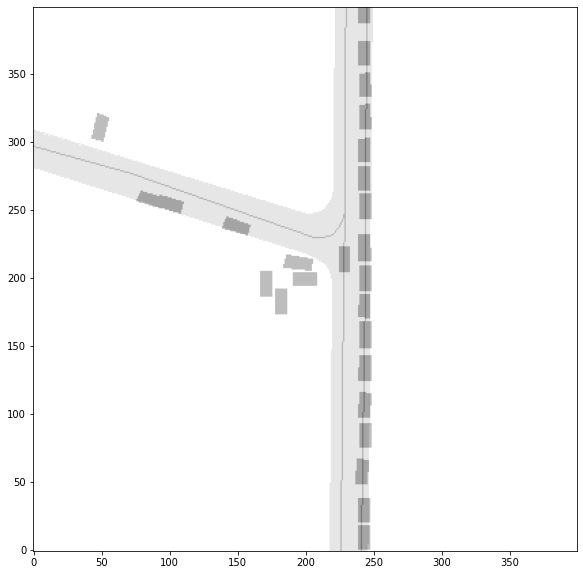

In [16]:
# Plot vehicles occupancy, pedestrian occupancy, lane occupancy and road polygon
plt.figure(figsize=(10, 10))
plt.imshow(data_item['feature_maps'][0], origin='lower', cmap='binary', alpha=0.7)
plt.imshow(data_item['feature_maps'][6], origin='lower', cmap='binary', alpha=0.5)
plt.imshow(data_item['feature_maps'][13], origin='lower', cmap='binary', alpha=0.2)
plt.imshow(data_item['feature_maps'][16], origin='lower', cmap='binary', alpha=0.1)

## Filtration by Tags

In [17]:
# To filter scenes by tags one should specify a filter function
# The scene tags dict has following structure:
# {
#     'day_time': one of {'kNight', 'kMorning', 'kAfternoon', 'kEvening'}
#     'season': one of {'kWinter', 'kSpring', 'kSummer', 'kAutumn'}
#     'track': one of {'Moscow' , 'Skolkovo', 'Innopolis', 'AnnArbor', 'Modiin', 'TelAviv'}
#     'sun_phase': one of {'kAstronomicalNight', 'kTwilight', 'kDaylight'}
#     'precipitation': one of {'kNoPrecipitation', 'kRain', 'kSleet', 'kSnow'}
# }
# Full description of protobuf message is available at tags.proto file in sources


def filter_scene(scene_tags_dict):
    if scene_tags_dict['track'] == 'Innopolis' and scene_tags_dict['precipitation'] == 'kRain':
        return True
    else:
        return False

In [18]:
# Trajectory tags list can include any number of the following non-mutually exclusive tags.
# [
#     'kMoveLeft', 'kMoveRight', 'kMoveForward', 'kMoveBack',
#     'kAcceleration', 'kDeceleration', 'kUniform',
#     'kStopping', 'kStarting', 'kStationary'
# ]


def filter_trajectory(trajectory_tags_list):
    if 'kMoveRight' in trajectory_tags_list:
        return True
    else:
        return False

In [19]:
# Let's try to filter scenes.
# We need to use development data as long as train data contains no scenes with precipitation.

dataset = MotionPredictionDataset(
    dataset_path=dataset_path,
    scene_tags_fpath=scene_tags_fpath,
    feature_producer=renderer,
    transform_ground_truth_to_agent_frame=True,
    scene_tags_filter=filter_scene,
    trajectory_tags_filter=filter_trajectory,
)

176/50000 scenes fit the filter criteria.


In [20]:
dataset_iter = iter(dataset)
for i in range(10):
    data_item = next(dataset_iter)

In [23]:
transformed_gt = transform_2d_points(data_item['ground_truth_trajectory'], renderer.to_feature_map_tf)
transformed_gt = np.round(transformed_gt - 0.5).astype(np.int32)

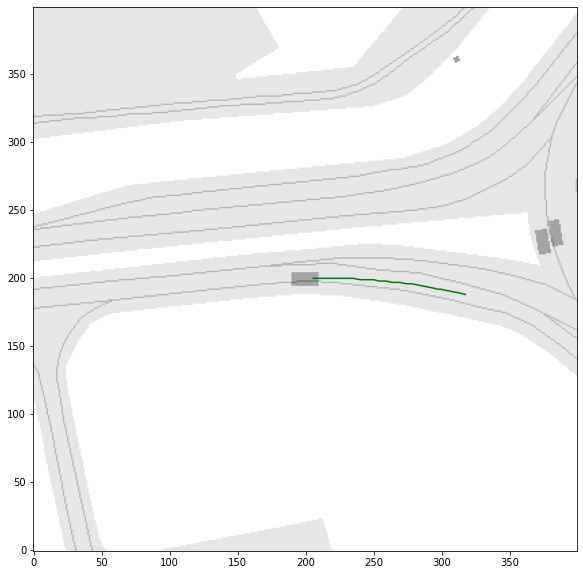

In [26]:
plt.figure(figsize=(10, 10))
plt.imshow(data_item['feature_maps'][0], origin='lower', cmap='binary', alpha=0.7)
plt.imshow(data_item['feature_maps'][6], origin='lower', cmap='binary', alpha=0.5)
plt.imshow(data_item['feature_maps'][13], origin='lower', cmap='binary', alpha=0.2)
plt.imshow(data_item['feature_maps'][16], origin='lower', cmap='binary', alpha=0.1)
ax = plt.gca()
ax.add_collection(mc.LineCollection([transformed_gt], color='green'))

## Prerendered Dataset

To avoid the cost of online rendering we provide rendered feature maps at 128x128 resolution with zlib compression level 1.

In [38]:
# Define the path to the pre-rendered feature maps corresponding to the dataset at "dataset_path".
prerendered_dataset_path = '/path/to/prerendered/dataset/'

# We use raw protobuf dataset here to extract ground truth trajectories
prerenderer_dataset = MotionPredictionDataset(
    dataset_path=dataset_path,
    scene_tags_fpath=scene_tags_fpath,
    prerendered_dataset_path=prerendered_dataset_path,
)

500000/500000 scenes fit the filter criteria.


In [39]:
dataset_iter = iter(prerenderer_dataset)
for i in range(10):
    item = next(dataset_iter)

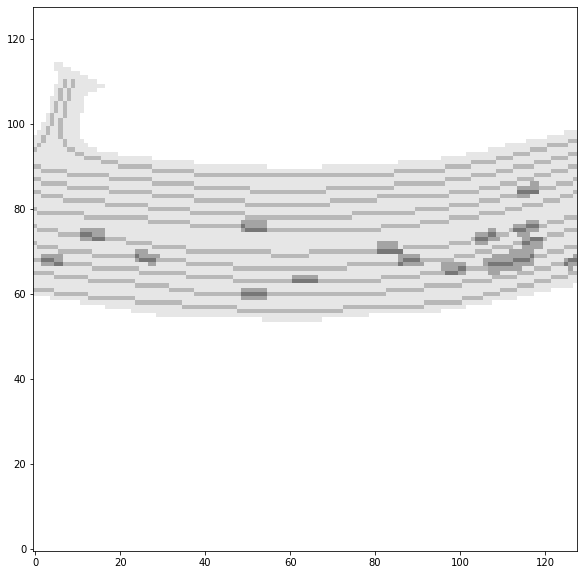

In [41]:
plt.figure(figsize=(10, 10))
plt.imshow(item['prerendered_feature_map'][0], origin='lower', cmap='binary', alpha=0.7)
plt.imshow(item['prerendered_feature_map'][6], origin='lower', cmap='binary', alpha=0.5)
plt.imshow(item['prerendered_feature_map'][13], origin='lower', cmap='binary', alpha=0.2)
plt.imshow(item['prerendered_feature_map'][16], origin='lower', cmap='binary', alpha=0.1)